In [1]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn

data_path = './../../data/processed/'

import numpy as np

import warnings
warnings.filterwarnings('ignore')

import json

vardict = json.load(open("variables.json"))
def add_entry(vardict, name, element):
    vardict[name]= element
    return vardict

In [2]:
# for col in ['CN ID 8', 'CPA6', 'ID', 'VAT', 'DEPT', 'PYOD']:
    
#     df = pd.read_csv(data_path + col.replace(' ', '_')+'_YM.csv')
#     df['date'] = pd.DatetimeIndex(pd.to_datetime(12*(df.YEAR - 1997) + df.MONTH, unit='M', origin=pd.Timestamp('1996-12-15'))).round('D')
    

## Data

In [3]:
col = 'ID'
df = pd.read_csv(data_path + col.replace(' ', '_')+'_YM.csv')
df['date'] = pd.DatetimeIndex(pd.to_datetime(12*(df.YEAR - 1997) + df.MONTH, unit='M', origin=pd.Timestamp('1996-12-15'))).round('D')


In [4]:
df.head()

,ID,IMPORT,YEAR,MONTH,VART,date
0,0,0,1997,1,2003887,1997-01-01
1,0,1,1997,1,3212282,1997-01-01
2,215,0,1997,1,53758,1997-01-01
3,223,1,1997,1,29123,1997-01-01
4,330,0,1997,1,2870,1997-01-01


## Size distribution

In [5]:
sizes = df.loc[(df.YEAR > 2010) & (df.IMPORT == 1)].groupby('ID')[['VART']].sum()
sizes['rank'] = sizes.VART.rank(ascending = False)

sizes = pd.concat([sizes, np.log10(sizes).add_prefix('log_')], axis = 1)

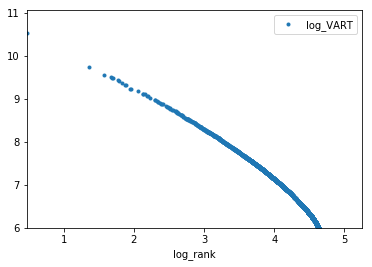

In [6]:
sizes.sample(frac = .1).plot(x = 'log_rank', y = 'log_VART', marker = '.', lw = 0)
plt.ylim(6, )
plt.show()

In [7]:
sizes.shape

(176710, 4)

In [8]:
# for y in range(1997, 2014, 4):
#     print(y)
#     sizes = df.loc[(df.YEAR == y) & (df.IMPORT == 1)].groupby('ID')[['VART']].sum()
#     sizes = pd.concat([sizes, np.log10(sizes).add_prefix('log_')], axis = 1)

#     sizes['log_VART_bin'] = pd.cut(sizes['log_VART'], np.arange(2, 11, .25))

#     counts = sizes.groupby('log_VART_bin').count()['VART']
#     vals = sizes.groupby('log_VART_bin').sum()['VART']
# #     np.log10(counts/counts.sum()).plot(marker = '.')
# #     np.log10(vals/vals.sum()).plot(marker = '.')
#     (counts/counts.sum()).plot(marker = '.')
#     (vals/vals.sum()).plot(marker = '.')
#     plt.show()

## Frequency of transactions

In [9]:
# cuadro = df.loc[df.IMPORT == 1].set_index(['ID', 'date'])[['VART']].unstack()

# Firms present in at least two separate months
# cuadro = cuadro.loc[cuadro.count(1) > 6]

In [10]:
# plt.hist(cuadro.count(1), bins = range(100))
# plt.show()

# ct, bn = np.histogram(cuadro.count(1), bins = range(100))

# x = bn[8:]
# y = 1/ct[7:]

# plt.plot(x, y, marker = '.')
# plt.show()

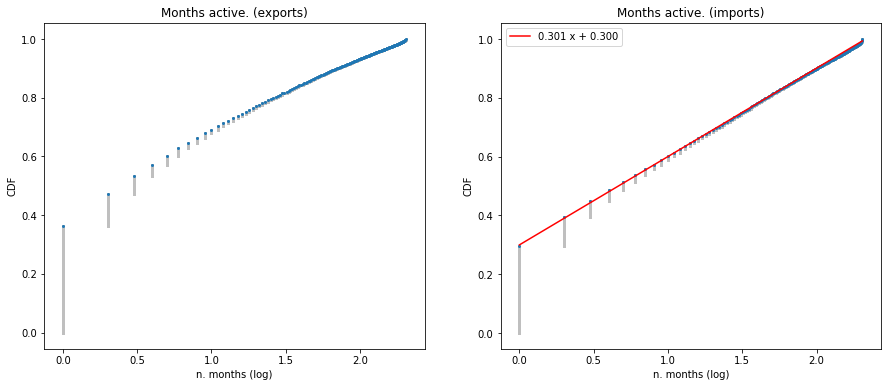

In [11]:
from scipy.optimize import curve_fit

def func(x, a, b):
    return a * x + b

fig, axs = plt.subplots(1, 2, figsize = (15, 6))

for i in range(2):
    ax = axs[i]
    ax.set_title('Months active. '+['(exports)', '(imports)'][i])
    
    cuadro = df.loc[df.IMPORT == i].set_index(['ID', 'date'])[['VART']].unstack()

    n_months = cuadro.count(1).sort_values()
    n_months = n_months.loc[n_months < 204]

    CDF = n_months.rank(pct=True, method = 'max')
    CDF_cont = np.arange(len(CDF))/len(CDF)
    log_months = np.log10(n_months)
    x = log_months; y = CDF

    cdf = pd.DataFrame([log_months, CDF], index = ['log_months', 'CDF']).T
    cdf = cdf.drop_duplicates()

    if i == 1:
        popt, pcov = curve_fit(func, x, y)
        errs = np.sqrt(np.diag(pd.DataFrame(pcov)))
        ax.plot(x, func(x, *popt), 'r-', label='%5.3f x + %5.3f' % tuple(popt))
        ax.legend()

    ax.scatter(x = log_months, y = CDF_cont, marker = '.', lw = 0, color = '.75')
    ax.scatter(x = cdf.log_months, y = cdf.CDF, marker = '.', lw = 0)
    ax.set_xlabel('n. months (log)'); ax.set_ylabel('CDF')
    
plt.savefig('./../../../thesis_writing/figures/month_distrib_pl.png', dpi = 300)
plt.show()

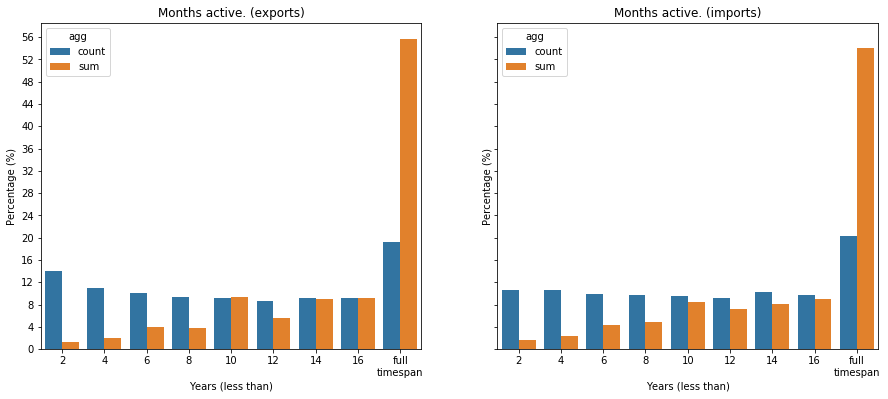

In [17]:
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize = (15, 6))

bar_chart_info_list = []

for i in [0, 1]:
    ax = axs[i]
    ax.set_title('Months active. '+['(exports)', '(imports)'][i])
    
    cuadro = df.loc[df.IMPORT == i].set_index(['ID', 'date'])[['VART']].unstack()
    n_months = cuadro.count(1).sort_values()
    
    n_months_cuadro = cuadro.copy()
    n_months_cuadro['n_months'] = n_months
    n_months_cuadro = n_months_cuadro.groupby('n_months').agg(['sum', 'count'])

    volume_by_n_months = n_months_cuadro.copy()
    n = 24
    volume_by_n_months.index = volume_by_n_months.index//n
    volume_by_n_months = volume_by_n_months.stack()
    volume_by_n_months = volume_by_n_months.groupby(level = [0, 1]).sum()
    volume_by_n_months = volume_by_n_months.sum(1).reset_index().rename(columns = {'level_1': 'agg'}).groupby(['n_months','agg']).sum()
    bar_chart_info = volume_by_n_months.groupby(level = 1).apply(lambda x: 100*x/x.sum()).reset_index().rename(columns = {0: 'pct'})

    bar_chart_info['Years'] = int(n/12)*bar_chart_info['n_months'].astype(int) + int(n/12)
    sns.barplot(x="Years", y="pct", hue="agg", data=bar_chart_info, ax = ax)

    
    ax.set_yticks(np.linspace(0, 56, num=15, endpoint=True))
    ax.set_ylim(0, 58)
    ax.set_ylabel('Percentage (%)')
    ax.set_xlabel('Years (less than)')
    
#     lbs = ['(%d, %d]'%(edges.left, edges.right) for edges in distrib_of_nunique.index]
#     lbs[-1] = lbs[-1].split(',')[0]+', '+str(int(effective_nunique[cut_col].max()))+']' # fix last one
#     ax.set_xticklabels(lbs, rotation = 30, ha = 'right')
    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels[-1] = 'full\ntimespan'
    ax.set_xticklabels(labels)
    
    bar_chart_info_list += [bar_chart_info]

plt.savefig('./../../../thesis_writing/figures/month_distrib_bc.png', dpi = 300)
plt.show()

In [13]:

# Save regression results
varnames_list = []
varnames_list += [['monthsActiveImpK0', "{:.3f}".format(round(popt[1], 3))]] 
varnames_list += [['monthsActiveImpK1', "{:.3f}".format(round(popt[0], 3))]]

for i in [0, 1]:
    bar_chart_info = bar_chart_info_list[i]    

    unstacked = bar_chart_info.set_index(['Years', 'agg'])[['pct']].unstack()
    unstacked_cs = unstacked.cumsum()

    yrs_half = unstacked_cs.loc[unstacked_cs[('pct', 'count')] > 50].index[0]
    cnt_half = int(unstacked_cs.loc[[yrs_half]][('pct', 'count')].values[0].round())
    val_half = int(unstacked_cs.loc[[yrs_half]][('pct', 'sum')].values[0].round())

    yrs_last_ix = unstacked.iloc[[-1]].index[0]
    cnt_last = int(unstacked.loc[[yrs_last_ix]][('pct', 'count')].values[0].round())
    val_last = int(unstacked.loc[[yrs_last_ix]][('pct', 'sum')].values[0].round())
    yrs_last = yrs_last_ix - int(n / 12)
    
    for j, var_value in enumerate([yrs_half, cnt_half, val_half, yrs_last, cnt_last, val_last]):
        name = ['yrs_half', 'cnt_half', 'val_half', 'yrs_last', 'cnt_last', 'val_last'][j]
        varname = 'monthsActive'+['Exports', 'Imports'][i][:3]+'_bc_'+name
        varnames_list += [[varname, str(var_value)]]
        
    for name in varnames_list:
        res = add_entry(vardict, *name)

    f = open("variables.json","w")
    f.write(json.dumps(res))
    f.close()

varnames_list

[['monthsActiveImpK0', '0.300'],
 ['monthsActiveImpK1', '0.301'],
 ['monthsActiveExp_bc_yrs_half', '10'],
 ['monthsActiveExp_bc_cnt_half', '54'],
 ['monthsActiveExp_bc_val_half', '21'],
 ['monthsActiveExp_bc_yrs_last', '16'],
 ['monthsActiveExp_bc_cnt_last', '19'],
 ['monthsActiveExp_bc_val_last', '56'],
 ['monthsActiveImp_bc_yrs_half', '10'],
 ['monthsActiveImp_bc_cnt_half', '50'],
 ['monthsActiveImp_bc_val_half', '22'],
 ['monthsActiveImp_bc_yrs_last', '16'],
 ['monthsActiveImp_bc_cnt_last', '20'],
 ['monthsActiveImp_bc_val_last', '54']]

## Growth rates. 
### Levels and self dependence

In [4]:
col = 'ID'
df = pd.read_csv(data_path + col.replace(' ', '_')+'_YM.csv')
df['date'] = pd.DatetimeIndex(pd.to_datetime(12*(df.YEAR - 1997) + df.MONTH, unit='M', origin=pd.Timestamp('1996-12-15'))).round('D')


In [5]:
cuadro = df.loc[df.IMPORT == 0].set_index(['ID', 'date'])[['VART']].unstack()

# Firms present in at least two separate months
cuadro = cuadro.loc[cuadro.count(1) > 6]

In [6]:
# Rolling si

cuadro_rolled = cuadro.rolling(12, axis = 1, center=True).sum()
cuadro_rolled = cuadro_rolled.dropna(axis = 1, how = 'all')

# Rolling no
# cuadro_rolled = cuadro

In [7]:
annual_log = np.log10(cuadro_rolled)
annual_log.columns = annual_log.columns.set_levels(annual_log.columns.levels[0].str.replace('VART', 'annual_log'), level=0)

# Not always necessary
# annual_log = np.log10(cuadro_rolled.reindex(annual_logdiff_prev.index))

# annual_logdiff = np.log10(cuadro_rolled).diff(12, axis = 1).dropna(how = 'all')
# annual_logdiff_prev = annual_logdiff.shift(12, axis = 1).dropna(how = 'all')
# annual_logdiff_prev.columns = annual_logdiff_prev.columns.set_levels(annual_logdiff_prev.columns.levels[0].str.replace('VART', 'annual_logdiff_prev'), level=0)
# annual_logdiff.columns = annual_logdiff.columns.set_levels(annual_logdiff.columns.levels[0].str.replace('VART', 'annual_logdiff'), level=0)

# df_concat = pd.concat([annual_log, annual_logdiff, annual_logdiff_prev], axis = 1)
# df_concat.shape

I would like to know what are the ranges that contain a single firm...

In [8]:
df_ = annual_log.copy()
df_.index = pd.cut(df_.median(1), np.arange(4, 10, .1))
sample = df_.groupby(df_.index, observed = True).apply(lambda x: x.sample(250, replace = True))
# df_.groupby(df_.index).count()# groupby some years and its a nice basic table

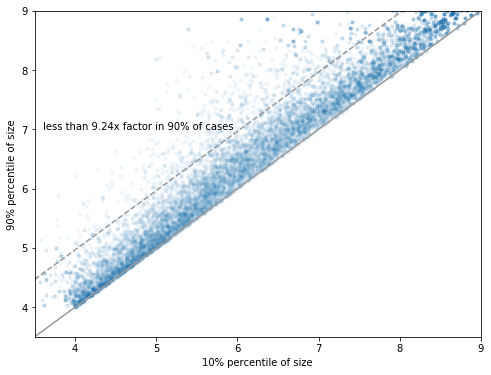

In [10]:

x = sample.quantile(.1, axis = 1)
y = sample.quantile(.9, axis = 1)

fig, ax = plt.subplots(1, figsize = (8, 6))

ax.plot(x, y, marker = '.', lw = 0, alpha = .05)
# plt.plot(x, y - x, marker = '.', lw = 0, alpha = .05)

ax.plot((3.5, 9), (3.5, 9), ls="-", c=".6")
q = (y - x).quantile(.9)
ax.plot((3.5, 9), (3.5 + q, 9 + q), ls="--", c=".6")

ax.set_xlim(3.5, 9)
ax.set_ylim(3.5, 9)
ax.set_xlabel('10% percentile of size')
ax.set_ylabel('90% percentile of size')
ax.annotate('less than '+ str(np.power(10, q).round(2)) + 'x factor in 90% of cases', xy = (3.6, 7))

plt.savefig('./../../../thesis_writing/figures/same_firm_variability.png', dpi = 300)
plt.show()
#Most firms oscillate in a band of 1.1 (12x)

## What does a period of activity/inactivity look like?

In [3]:
for i in range(2):
    cuadro = df.loc[df.IMPORT == i].set_index(['ID', 'date'])[['VART']].unstack()

In [5]:
i = 0
cuadro = df.loc[df.IMPORT == i].set_index(['ID', 'date'])[['VART']].unstack()['VART']

In [14]:
df_ = (cuadro > 0).loc[((cuadro > 0).sum(1) > 1) & ((cuadro > 0).sum(1) <= 200)]
df_ = df_.head(1000)

In [8]:

b = df_.cumsum(1)

#how long since current active period started
c1 = b.sub(b.mask(df_).ffill(1).fillna(0)).astype(int)

b = (~df_).cumsum(1)

#how long since current INactive period started
c0 = -b.sub(b.mask(~df_).ffill(1).fillna(0)).astype(int)


b = (~df_.T.sort_index(ascending = False).T).cumsum(1)
#how long for current INactive to end
c0_ = -b.sub(b.mask(~df_).ffill(1).fillna(0)).astype(int)
c0_ = c0_.T.sort_index().T

c0_max = np.minimum(c0, c0_)

# #get maximal value of all columns
# length = c.max().tolist()
# print (length)
# [3, 4, 2]

# #get indexes by maximal value, subtract length and add 1 
# index = c.idxmax().sub(length).add(1).tolist()
# print (index)
# [5, 2, 7]

In [9]:
c1 + c0_max

date,1997-01-01 00:00:00,1997-01-31 00:00:00,1997-03-02 00:00:00,1997-04-02 00:00:00,1997-05-02 00:00:00,1997-06-02 00:00:00,1997-07-02 00:00:00,1997-08-02 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,...,2013-03-02 00:00:00,2013-04-02 00:00:00,2013-05-02 00:00:00,2013-06-02 00:00:00,2013-07-02 00:00:00,2013-08-01 00:00:00,2013-09-01 00:00:00,2013-10-01 00:00:00,2013-11-01 00:00:00,2013-12-01 00:00:00
ID,,,,,,,,,,,,,,,,,,,,,
0,1,2,3,4,5,6,7,8,9,10,...,-8,-9,-10,-11,-12,-13,-14,-15,1,-1
215,1,2,3,4,-4,-3,-3,-4,1,2,...,-25,-26,-27,-28,-29,-30,-31,-32,-33,-34
223,-93,-92,-91,-90,-89,-88,-87,-86,-85,-84,...,-90,-91,-92,-93,-94,-95,-96,-97,-98,-99
256,-58,-57,-56,-55,-54,-53,-52,-51,-50,-49,...,-117,-118,-119,-120,-121,-122,-123,-124,-125,-126
314,-35,-34,-33,-32,-31,-30,-29,-28,-27,-26,...,-129,-130,-131,-132,-133,-134,-135,-136,-137,-138
330,1,2,3,4,-1,1,-5,-4,-3,-4,...,1,2,3,-1,1,2,-2,-2,1,-1
355,-13,-12,-11,-10,-9,-8,-7,-8,-9,-10,...,-6,1,-8,-7,-6,-5,-5,-6,-7,-8
356,-98,-97,-96,-95,-94,-93,-92,-91,-90,-89,...,-50,-51,-52,-53,-54,-55,-56,-57,-58,-59
392,-61,-60,-59,-58,-57,-56,-55,-54,-53,-52,...,-122,-123,-124,-125,-126,-127,-128,-129,-130,-131
